In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import brentq

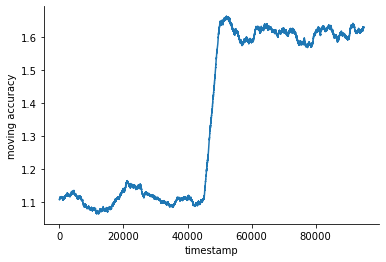

In [2]:
# Load cached data from Shifts (Yandex Weather Prediction). See https://github.com/Shifts-Project/shifts for details.
# The data has a change point halfway through.
data = np.load('../data/weather/weather-catboost.npz')
preds = data['preds'][:,::1,:]
temperatures = data['temperatures'][::1] # Temperature (degrees Celsius)
times = data['times'][::1] # Times

pred_mean = preds[:,:,0].mean(axis=0)
pred_uncertainty = preds[:,:,1].mean(axis=0)

# Visualize the average accuracy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

sort_idx = np.argsort(times)
pred_mean = pred_mean[sort_idx]
temperatures = temperatures[sort_idx]
times = times[sort_idx]

accuracy_over_time = moving_average(np.abs(pred_mean[sort_idx]-temperatures[sort_idx]), 5000)


plt.plot(np.arange(accuracy_over_time.shape[0]), accuracy_over_time)
plt.xlabel('timestamp')
plt.ylabel('moving accuracy')
sns.despine(top=True,right=True)
plt.show()

In [3]:
# Problem setup
alpha = 0.1 # 1-alpha is the desired coverage
K=100; weights = np.ones((K,)); w = weights.sum() # Take a fixed window of K
wtildes = weights/(weights.sum() + 1)

In [4]:
# Use the uncertainty scalars method to get conformal scores
scores = np.abs(pred_mean-temperatures)/pred_uncertainty
# Get the weighted score quantile at each time step
def get_weighted_quantile(scores,T):
    score_window = scores[T-K:T]
    def critical_point_quantile(q): return (wtildes * (score_window <= q)).sum() - (1 - alpha - 1/(w+1))
    return brentq(critical_point_quantile, 0, 100)

qhats = np.array( [get_weighted_quantile(scores, t) for t in range(K+1, scores.shape[0])] )
# Deploy (output=lower and upper adjusted quantiles)
prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*qhats]

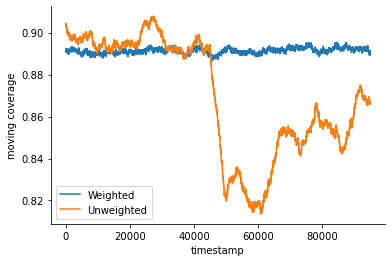

In [5]:
prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*qhats]
covered = ( temperatures[K+1:] >= prediction_sets[0] ) & ( temperatures[K+1:] <= prediction_sets[1] )
coverage_over_time = moving_average(covered, 5000)

naive_qhats = np.array( [np.quantile(scores[:t], np.ceil((t+1)*(1-alpha))/t, interpolation='higher') for t in range(K+1, scores.shape[0]) ] )
naive_prediction_sets = [pred_mean[K+1:] - pred_uncertainty[K+1:]*naive_qhats, pred_mean[K+1:] + pred_uncertainty[K+1:]*naive_qhats]
naive_covered = ( temperatures[K+1:] >= naive_prediction_sets[0] ) & ( temperatures[K+1:] <= naive_prediction_sets[1] )
naive_coverage_over_time = moving_average(naive_covered, 5000)

plt.plot(coverage_over_time, label='Weighted');
plt.plot(naive_coverage_over_time, label='Unweighted');
sns.despine(top=True,right=True)
plt.xlabel('timestamp')
plt.ylabel('moving coverage')
plt.legend();

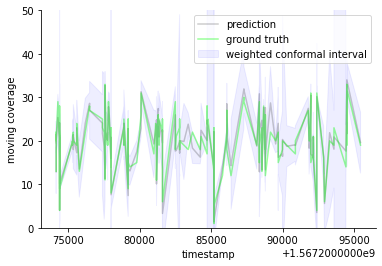

In [6]:
# Plot prediction sets
start_point = 99700
fig, ax = plt.subplots()
ax.plot(times[K+1:][start_point:],pred_mean[K+1:][start_point:],color='#00000033',label='prediction')
ax.plot(times[K+1:][start_point:],temperatures[K+1:][start_point:],color='#00FF0066', label='ground truth')
sns.despine(top=True,right=True)
ax.fill_between(times[K+1:][start_point:], prediction_sets[0][start_point:], prediction_sets[1][start_point:], color='#0000FF11', label='weighted conformal interval');
plt.ylim(0,50);
plt.xlabel('timestamp')
plt.ylabel('moving coverage')
plt.legend();